In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import reduce
from scipy.stats import linregress
from scipy import fftpack
from scipy.signal import detrend
from tqdm import tqdm
from scipy.optimize import root_scalar
from tqdm import tqdm
from scipy.optimize import curve_fit
from tsmoothie.smoother import LowessSmoother
import matplotlib

In [2]:
'''
Cell size evolution m(t)
'''
def m_function(t, mb, omega1 = 1, v = 1):
    

    m_ = (mb)*np.exp(omega1*t)
    return m_


'''
Protein content evolution p(t)
'''
def p_function(t, mb, omega1 = 1, v = 1):
    

    
    p_ = (mb)*(np.exp(omega1*t) - 1)
    return p_


'''
Hazard rate function h(t)
'''
def h(t, mb, u, omega2, omega1 = 1, v = 1):

    h_ = omega2*((p_function(t, mb, omega1, v) + v)/(u+v)) # if p(t) ≥ mu
    h_[p_function(t, mb, omega1 = 1, v = 1) < u] = 0                 # if p(t) < mu
    
    return h_


'''
Logarithm of survival function s(t) for a float t
'''
def log_CDF_float(t, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    t0 = (1.0/omega1) * np.log(1 + (u/mb))
    #t0 = max([0, (1.0/omega1) * np.log(1 + (mu/mb))])
    if t>=t0:
        ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +\
                    ((v-mb)/(u+v)) * omega2 * (t-t0) )
    else:
        ln_s_ = 0

    return ln_s_


'''
Logarithm of survival function s(t) for an array t
'''
# threshold time

def log_CDF_arr(t, mb, u, omega2, omega1 = 1, v = 1):
    

    t0 = (1.0/omega1) * np.log(1 + (u/mb))
    

    ln_s_ = - ( (mb/(u+v)) * (omega2/omega1) * (np.exp(omega1*t)-np.exp(omega1*t0)) +((v-mb)/(u+v)) * omega2 * (t-t0) )
    
    
    
    ln_s_[t < t0] = 0                 # if p(t) < mu

    return ln_s_


'''
Logarithm of survival function s(t)
'''
def log_CDF(t, mb, u, omega2, omega1 = 1, v = 1):

    if type(t) == np.ndarray: # array
        ln_s_ = log_CDF_arr(t, mb, u, omega2, omega1, v)
    else: # float
        ln_s_ = log_CDF_float(t, mb, u, omega2, omega1, v)

    return ln_s_


'''
Survival function s(t)
'''
def CDF(t, mb, u, omega2, omega1 = 1, v = 1):
    return np.exp(log_CDF(t, mb, u, omega2, omega1, v))

'''
Find tau numerically
'''
def draw_tau_numerical(K, mb, u, omega2, omega1 = 1, v = 1):
    

    # threshold time
    t0 = max([0, (1.0/omega1) * np.log(1 + (u/mb))])


    sol = root_scalar(lambda t: CDF(t, mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v) - K, bracket=[t0, 40], method='brentq')
    tau = sol.root
    return tau

In [3]:
def sizesAtBirth(omega2, omega1 = 1, mb0 = 1, u = 0, v = 1, seriesLength = 5000):
    pointsPerEvolution = 200 # Number of points per cell division
    sizesAtBirth = np.zeros(seriesLength)
    interDivisionTimes = np.zeros(seriesLength)
    
    
    s_drawn = np.random.uniform(low=0, high = 1, size = seriesLength)
    # Initialize the cell size array
    cellSizes = np.zeros(pointsPerEvolution*seriesLength)
    mb = mb0
    t = 0
    for i in range(seriesLength): 
        sizesAtBirth[i] = mb
        #parameters = (1,0.9,0.1,1,mb) # omega1, omega2, mu, nu, xb
        
        tau = draw_tau_numerical(s_drawn[i],  mb = mb, u = u, omega2 = omega2, omega1 = omega1, v = v)
        interDivisionTimes[i] = tau
        #sim_t.append(tau)

        # evolution
        times = np.linspace(0, tau, pointsPerEvolution)
        mt = m_function(times,  mb = mb, omega1 = omega1, v = v)
        # pt = p_function(times, parameters)
        
        # store times and sizes
        #all_times[i*points_per_evolution : (i+1)*points_per_evolution] = np.linspace(t, t+tau, points_per_evolution)
        cellSizes[i*pointsPerEvolution : (i+1)*pointsPerEvolution] = mt

        # update the initial time and the starting size
        mb = mt[-1]*(1/2)
        t = t+tau
    
    return sizesAtBirth, interDivisionTimes, cellSizes


In [4]:
criticalPoint = 1 / np.log(2)
seriesLength = 10000
omega2Values = np.linspace(0.1, criticalPoint, 15)
sizesAtBirthArray = np.zeros((len(omega2Values), seriesLength))
interDivisionTimesArray = np.zeros((len(omega2Values), seriesLength))

for i in tqdm(range(len(omega2Values))):
    sizesAtBirth_, interDivisionTimes_, _ = sizesAtBirth(omega2 = omega2Values[i], seriesLength = seriesLength) 
    sizesAtBirthArray[i,:] = sizesAtBirth_
    interDivisionTimesArray[i,:] = interDivisionTimes_

100%|██████████| 15/15 [00:19<00:00,  1.29s/it]


100%|██████████| 15/15 [00:00<00:00, 330.83it/s]


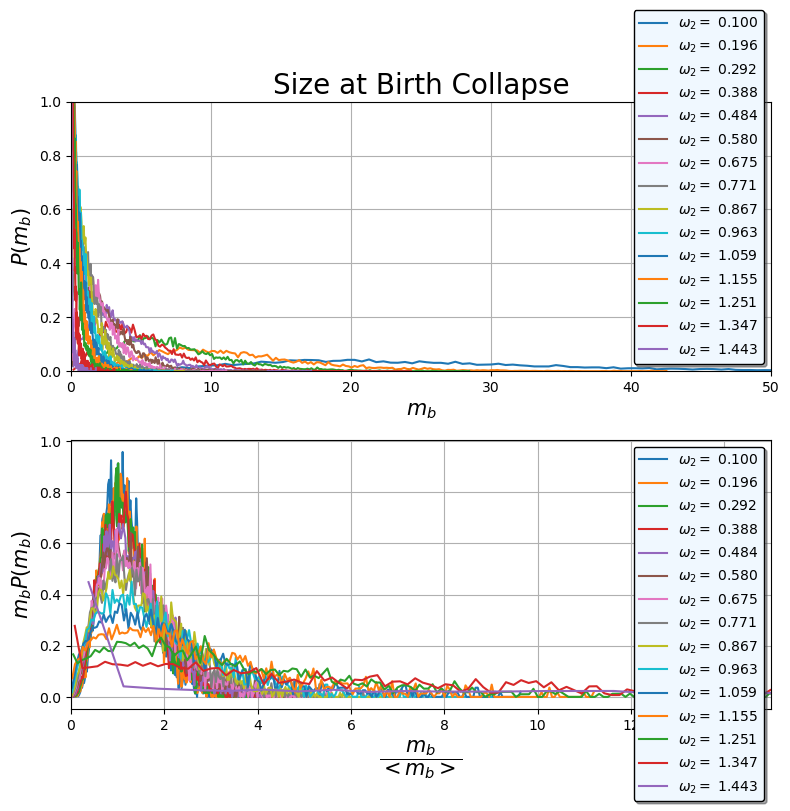

In [5]:
fig, axArr = plt.subplots(2, 1, figsize = (8, 8), tight_layout = True)
ax, ax1 = axArr.flatten()
for i in tqdm(range(len(omega2Values))):
    counts, edges  = np.histogram(sizesAtBirthArray[i,:], bins = 200, density = True)
    binCenters = (edges[1:] + edges[:-1])/2
    ax.plot(binCenters, counts, label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2)
    meanSize = np.mean(sizesAtBirthArray[i,:])
    ax1.plot(binCenters / meanSize, counts * binCenters, label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2)
ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
ax.set_ylabel('$P(m_b)$', fontsize = 15)
ax1.set_ylabel('$m_b P(m_b)$', fontsize = 15)
ax1.set_xlabel('$\\dfrac{m_b}{<m_b>}$', fontsize = 15)
ax.set_xlabel('$m_b$', fontsize = 15)
ax.set_ylim(0, 1)
ax.set_xlim(0, 50)
ax1.set_xlim(0, 15)
ax1.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
ax.set_title('Size at Birth Collapse', fontsize = 20)
ax.grid(zorder = 1)
ax1.grid(zorder = 1)
plt.show()

100%|██████████| 15/15 [00:00<00:00, 373.41it/s]


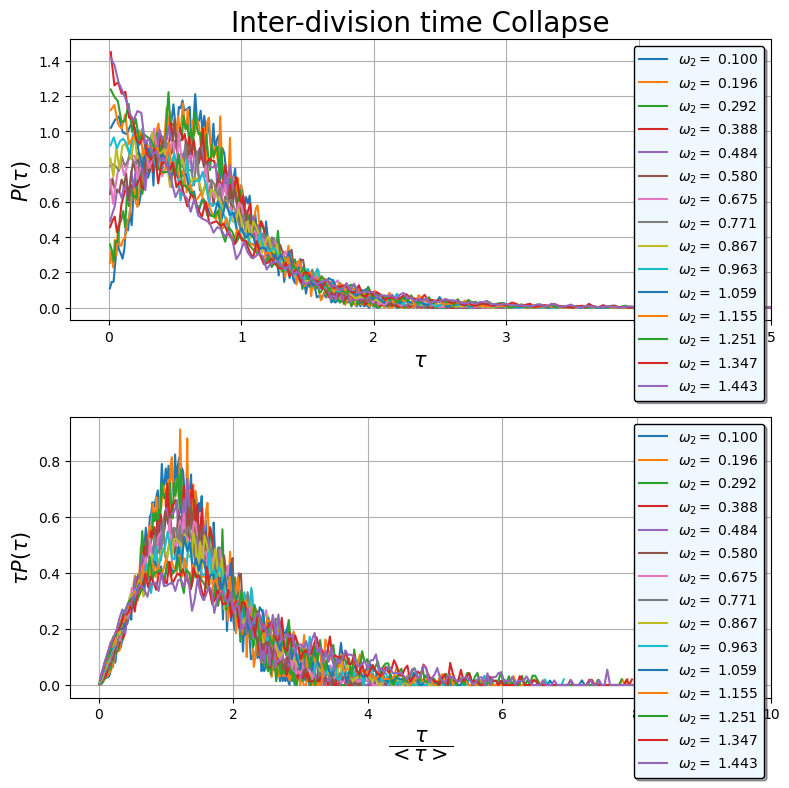

In [6]:
fig, axArr = plt.subplots(2, 1, figsize = (8, 8), tight_layout = True)
ax, ax1 = axArr.flatten()
for i in tqdm(range(len(omega2Values))):
    counts, edges  = np.histogram(interDivisionTimesArray[i,:], bins = 200, density = True)
    binCenters = (edges[1:] + edges[:-1])/2
    ax.plot(binCenters, counts, label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2)
    meanTime = np.mean(interDivisionTimesArray[i,:])
    ax1.plot(binCenters / meanTime, counts * binCenters, label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2)
ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
#ax.set_ylim(0, 1)
ax.set_ylabel('$P(\\tau)$', fontsize = 15)
ax1.set_ylabel('$\\tau P(\\tau)$', fontsize = 15)
ax1.set_xlabel('$\\dfrac{\\tau}{<\\tau>}$', fontsize = 15)
ax.set_xlabel('$\\tau$', fontsize = 15)
ax.set_xlim(right = 5)
ax1.set_xlim(right = 10)
ax1.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)
ax.grid(zorder = 1)
ax1.grid(zorder = 1)
ax.set_title('Inter-division time Collapse', fontsize = 20)
plt.show()

In [7]:
def kthMoment(array, k):
    return np.mean(array**k)

kValues = [0.5, 1, 1.5, 2]
kMomentsSizeFrac = np.zeros((len(omega2Values), len(kValues)))
for i in tqdm(range(len(omega2Values))):
    for j in range(len(kValues)):
        kMomentsSizeFrac[i,j] = kthMoment(sizesAtBirthArray[i,:], kValues[j] + 1) / kthMoment(sizesAtBirthArray[i,:],kValues[j])

100%|██████████| 15/15 [00:00<00:00, 681.11it/s]


In [8]:
kMomentsTimeFrac = np.zeros((len(omega2Values), len(kValues)))
for i in tqdm(range(len(omega2Values))):
    for j in range(len(kValues)):
        kMomentsTimeFrac[i,j] = kthMoment(interDivisionTimesArray[i,:], kValues[j] + 1) / kthMoment(interDivisionTimesArray[i,:], kValues[j])

100%|██████████| 15/15 [00:00<00:00, 706.15it/s]


Text(0.5, 1.0, 'Size subsequent moments ratio')

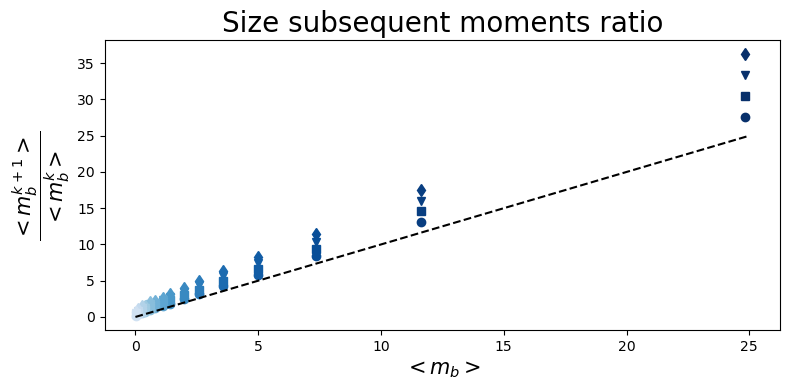

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4), tight_layout = True)
markers = ['o', 's', 'v', 'd']
cmap = plt.get_cmap('Blues_r')
colors = cmap(np.linspace(0, 0.8, len(omega2Values)))
for i in range(len(omega2Values)):
    meanSize = np.mean(sizesAtBirthArray[i,:])
    for j in range(len(kValues)):
        ax.plot(meanSize, kMomentsSizeFrac[i,j], label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2,\
                marker = markers[j], color = colors[i])
xAxis = np.linspace(0, 25, 100)
slope = 1
ax.plot(xAxis, xAxis * slope, '--', color = 'black', zorder = 3)
ax.set_xlabel('$<m_b>$', fontsize = 15)
ax.set_ylabel('$\\dfrac{<m_b^{k+1}>}{<m_b^k>}$', fontsize = 15)
ax.set_title('Size subsequent moments ratio', fontsize = 20)
#ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)

Text(0.5, 1.0, 'Inter-division time subsequent moments ratio')

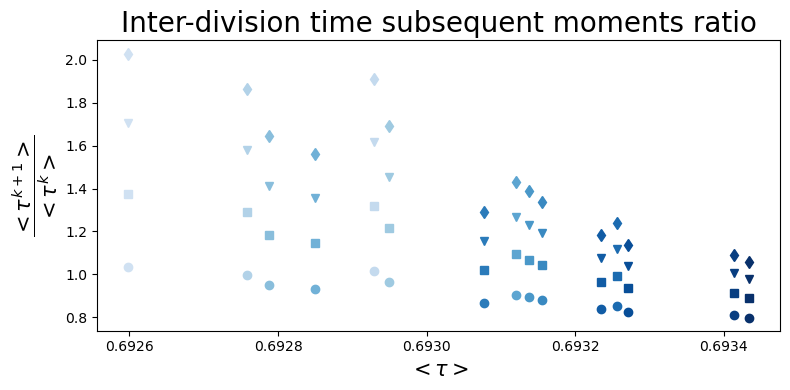

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4), tight_layout = True)
markers = ['o', 's', 'v', 'd']
cmap = plt.get_cmap('Blues_r')
colors = cmap(np.linspace(0, 0.8, len(omega2Values)))
for i in range(len(omega2Values)):
    meanTime = np.mean(interDivisionTimesArray[i,:])
    for j in range(len(kValues)):
        ax.plot(meanTime, kMomentsTimeFrac[i,j], label = f'$\omega_2 = $ {omega2Values[i]:.3f}', zorder = 2,\
                marker = markers[j], color = colors[i])
#xAxis = np.linspace(0, 25, 100)
ax.set_xlabel('$<\\tau>$', fontsize = 15)
ax.set_ylabel('$\\dfrac{<\\tau^{k+1}>}{<\\tau^k>}$', fontsize = 15)
ax.set_title('Inter-division time subsequent moments ratio', fontsize = 20)
#ax.plot(xAxis, xAxis * slope, '--', color = 'black', zorder = 3)
#ax.legend(facecolor = 'aliceblue', edgecolor = 'black', shadow = True)